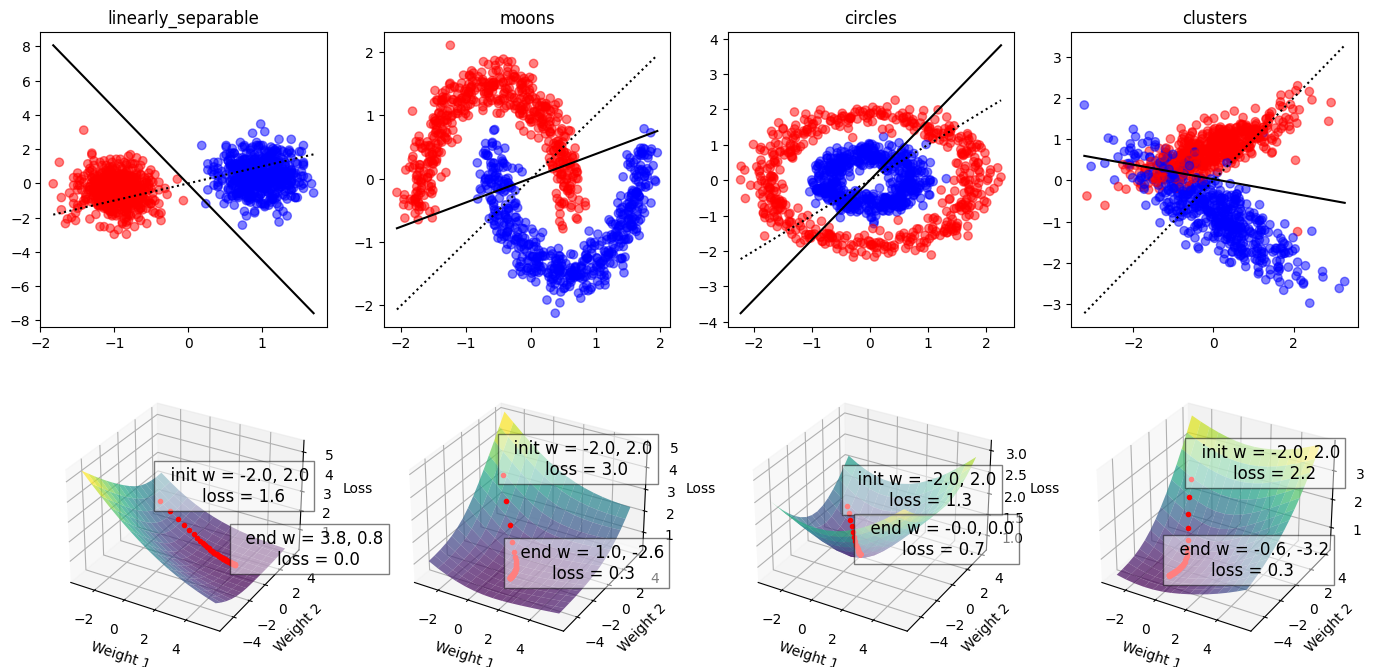

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.preprocessing import StandardScaler
from typing import Tuple, Dict
from dataclasses import dataclass

# Type aliases and constants
DataSet = Tuple[np.ndarray, np.ndarray]
DataSets = Dict[str, DataSet]

N_SAMPLES = 1000
RANDOM_STATE = 1
CM_BRIGHT = ListedColormap(["#FF0000", "#0000FF"])


def make_linearly_separable(n_samples: int = 100, random_state: int = 42) -> DataSet:
    """Generate linearly separable data."""
    np.random.seed(random_state)
    class_size = n_samples // 2

    X1 = np.random.normal(0, 1, (class_size, 2)).round(1)
    X2 = np.random.normal(0, 1, (class_size, 2)).round(1) + [7, 1]
    X = np.vstack((X1, X2))
    y = np.hstack((np.zeros(class_size), np.ones(class_size)))

    perm = np.random.permutation(len(X))
    return X[perm], y[perm]


def generate_datasets() -> DataSets:
    """Generate multiple datasets including linearly separable data."""
    datasets = {
        "linearly_separable": make_linearly_separable(N_SAMPLES, RANDOM_STATE),
        "moons": make_moons(noise=0.1, random_state=RANDOM_STATE, n_samples=N_SAMPLES),
        "circles": make_circles(
            noise=0.1, factor=0.4, random_state=RANDOM_STATE, n_samples=N_SAMPLES
        ),
        "clusters": make_classification(
            n_features=2,
            n_redundant=0,
            n_informative=2,
            random_state=RANDOM_STATE,
            n_clusters_per_class=1,
            n_samples=N_SAMPLES,
        ),
    }

    scaler = StandardScaler()
    return {name: (scaler.fit_transform(X), y) for name, (X, y) in datasets.items()}


def plot_decision_boundary(
    ax: plt.Axes,
    X: np.ndarray,
    w: np.ndarray,
    b: float,
    alpha: float = 1,
    label: str = "init",
) -> None:
    """Plot decision boundary given weight vector."""
    color = "k" if label in ["init", "end"] else "y"
    ls = "-" if label == "end" else "dotted"

    x1_vals = np.linspace(X[:, 0].min(), X[:, 0].max(), 10)
    x2_vals = -(w[0] * x1_vals + b) / (w[1] + 1e-10)  # Avoid division by zero
    ax.plot(x1_vals, x2_vals, ls=ls, color=color, alpha=alpha, label=label)


@dataclass
class Perceptron:
    learning_rate: float = 1
    epochs: int = 50

    def __post_init__(self):
        self.w = np.array([-2.0, 2.0])
        self.b = 0.0

    @staticmethod
    def sigmoid(z: np.ndarray) -> np.ndarray:
        """Apply sigmoid activation function."""
        return 1 / (1 + np.exp(-z))

    @staticmethod
    def binary_cross_entropy(
        y_pred: np.ndarray, y: np.ndarray, eps: float = 1e-9
    ) -> float:
        """Calculate binary cross entropy loss."""
        return -np.mean(y * np.log(y_pred + eps) + (1 - y) * np.log(1 - y_pred + eps))

    def predict(self, X: np.ndarray, w: np.ndarray, b: float) -> np.ndarray:
        """Forward pass through the perceptron."""
        return self.sigmoid(np.dot(X, w) + b)

    def loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray, b: float) -> float:
        """Calculate loss for given weights."""
        return self.binary_cross_entropy(self.predict(X, w, b), y)

    def get_gradients(self, X: np.ndarray, y: np.ndarray) -> Tuple[np.ndarray, float]:
        """Compute gradients for weights and bias."""
        y_pred = self.predict(X, self.w, self.b)
        error = y_pred - y
        return np.dot(X.T, error) / len(X), np.mean(error)

    def fit(self, X: np.ndarray, y: np.ndarray) -> np.ndarray:
        """Train the perceptron and return training path."""
        path = [(self.w[0], self.w[1], self.b, self.loss(X, y, self.w, self.b))]

        for _ in range(self.epochs):
            dw, db = self.get_gradients(X, y)
            self.w -= self.learning_rate * dw
            self.b -= self.learning_rate * db
            path.append((self.w[0], self.w[1], self.b, self.loss(X, y, self.w, self.b)))

        return np.array(path)


def plot_datasets(datasets: DataSets) -> None:
    """Plot training and test sets for all datasets with decision boundaries."""
    w1_range = np.linspace(-3, 5.5, 15)
    w2_range = np.linspace(-5, 4, 15)
    W1, W2 = np.meshgrid(w1_range, w2_range)

    fig, axs = plt.subplots(
        2, len(datasets), figsize=(17, 8), gridspec_kw={"height_ratios": [1, 0.9]}
    )

    for i, (name, (X, y)) in enumerate(datasets.items()):
        # Plot data points
        ax = axs[0, i]
        ax.scatter(X[:, 0], X[:, 1], c=y, cmap=CM_BRIGHT, alpha=0.5)
        ax.set_title(name)

        # Train perceptron and get path
        model = Perceptron()
        path = model.fit(X, y)

        # Plot decision boundaries
        plot_decision_boundary(ax, X, path[0, :2], path[0, 2], label="init")
        plot_decision_boundary(ax, X, path[-1, :2], path[-1, 2], label="end")

        # Create loss surface plot
        losses = np.array(
            [
                [model.loss(X, y, [w1, w2], 0) for w1, w2 in zip(W1_row, W2_row)]
                for W1_row, W2_row in zip(W1, W2)
            ]
        )

        # Setup 3D plot
        axs[1, i].remove()
        ax3d = fig.add_subplot(2, len(datasets), len(datasets) + i + 1, projection="3d")
        ax3d.plot_surface(W1, W2, losses, cmap="viridis", alpha=0.7)
        ax3d.plot(
            path[:, 0],
            path[:, 1],
            path[:, 3],
            "ro",
            markersize=3,
            label="Gradient Descent Path",
            zorder=10,
        )

        ax3d.set(xlabel="Weight 1", ylabel="Weight 2", zlabel="Loss")

        # Add annotations for start/end points
        for point, point_type in [(path[0], "init"), (path[-1], "end")]:
            ax3d.text(
                point[0],
                point[1],
                point[3],
                f"  {point_type} w = {point[0]:.1f}, {point[1]:.1f}\n"
                f"        loss = {point[3]:.1f}",
                color="black",
                fontsize=12,
                zorder=10,
                bbox=dict(facecolor="white", alpha=0.5),
            )

    plt.show()


if __name__ == "__main__":
    datasets = generate_datasets()
    plot_datasets(datasets)